In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


import math
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import scipy.sparse as sp


import subprocess
import json
import tempfile
from transformers import RobertaTokenizer

from collections import defaultdict

from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score
)
from tqdm import tqdm

# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
def drop_node(feats, drop_rate,training=True,seed=42):
    """
    Args:
        feats (Tensor): 节点特征 [batch_size, num_nodes, feature_dim] 或 [num_nodes, feature_dim]
        drop_rate (float): 丢弃概率。

    Returns:
        Tensor: 丢弃后的节点特征，与输入形状一致。
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if not training or drop_rate <= 0.0:
        return feats
    if feats.dim() == 2:  # [num_nodes, feature_dim]
        num_nodes, feature_dim = feats.shape
        drop_rates = torch.full((num_nodes,), drop_rate, device=feats.device, dtype=feats.dtype)  # [num_nodes]
        if training:
            masks = torch.bernoulli(1. - drop_rates).unsqueeze(1).expand(-1, feature_dim)  # [num_nodes, feature_dim]
            feats = masks * feats
        else :
            feats = feats * (1. - drop_rate)
    elif feats.dim() == 3:  # [batch_size, num_nodes, feature_dim]
        batch_size, num_nodes, feature_dim = feats.shape
        drop_rates = torch.full((batch_size, num_nodes), drop_rate, device=feats.device, dtype=feats.dtype)  # [batch_size, num_nodes]
        if training:
            masks = torch.bernoulli(1. - drop_rates).unsqueeze(2).expand(-1, -1, feature_dim)  # [batch_size, num_nodes, feature_dim]
            feats = masks * feats
        else :
            feats = feats * (1. - drop_rate)
    else:
        raise ValueError(f"Unsupported feats dimension: {feats.dim()}")

    return feats


class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, input_dropout, hidden_dropout, batchnorm):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(in_dim, hid_dim)
        self.layer2 = nn.Linear(hid_dim, out_dim)
        self.input_dropout = nn.Dropout(input_dropout)
        self.hidden_dropout = nn.Dropout(hidden_dropout)
        self.bn1 = nn.BatchNorm1d(in_dim) if batchnorm else None
        self.bn2 = nn.BatchNorm1d(hid_dim) if batchnorm else None

    def reset_parameters(self):
        self.layer1.reset_parameters()
        self.layer2.reset_parameters()

    def forward(self, x):
        if self.bn1:
            x = self.bn1(x)
        x = self.input_dropout(x)
        x = F.relu(self.layer1(x))
        if self.bn2:
            x = self.bn2(x)
        x = self.hidden_dropout(x)
        x = self.layer2(x)
        return x






class GGGNN(nn.Module):
    def __init__(self, feature_dim_size, hidden_size, num_GNN_layers, dropout, act=nn.functional.relu):
        super(GGGNN, self).__init__()
        self.num_GNN_layers = num_GNN_layers
        self.emb_encode = nn.Linear(feature_dim_size, hidden_size)
        self.dropout_encode = nn.Dropout(dropout)
        self.z0 = nn.Linear(hidden_size, hidden_size)
        self.z1 = nn.Linear(hidden_size, hidden_size)
        self.r0 = nn.Linear(hidden_size, hidden_size)
        self.r1 = nn.Linear(hidden_size, hidden_size)
        self.h0 = nn.Linear(hidden_size, hidden_size)
        self.h1 = nn.Linear(hidden_size, hidden_size)
        self.soft_att = nn.Linear(hidden_size, 1)
        self.ln = nn.Linear(hidden_size, hidden_size)
        self.act = act

    def gatedGNN(self, x, adj):
        a = torch.matmul(adj, x)
        # update gate
        z0 = self.z0(a)
        z1 = self.z1(x)
        z = torch.sigmoid(z0 + z1)
        # reset gate
        r = torch.sigmoid(self.r0(a) + self.r1(x))
        # update embeddings
        h = self.act(self.h0(a) + self.h1(r * x))

        return h * z + x * (1 - z)

    def forward(self, inputs, adj, mask):        # mask [B, N]
        x = self.dropout_encode(inputs)
        x = self.emb_encode(x)          # [B, N, H]
        mask_3d = mask.unsqueeze(-1)             # [B, N, 1]

        x = x * mask_3d                          # 广播到 [B, N, H]
        for _ in range(self.num_GNN_layers):
            x = self.gatedGNN(x, adj) * mask_3d  # 避免重复 unsqueeze
        return x

In [3]:
class GRAND_GatedFusion(nn.Module):
    def __init__(self,
                 in_dim,
                 hid_dim,
                 S=5,
                 K=3,
                 num_GNN_layers=2,
                 node_dropout=0.05,
                 input_droprate=0.1,
                 hidden_droprate=0.1,
                 batchnorm=False,
                 att_op='sum',
                 num_heads=8,
                 temp=0.5,
                 lam=1.0,
                 gnn_dropout=0.1,
                 args=None):
        super(GRAND_GatedFusion, self).__init__()
        self.S = S
        self.K = K
        self.args = args
        self.node_dropout_rate = node_dropout
        self.att_op = att_op
        self.temp = temp
        self.lam = lam
        
        # GRAND components
        self.grand_mlp = MLP(in_dim, hid_dim, hid_dim, input_droprate, hidden_droprate, batchnorm)
        
        # Gated GNN components
        self.gggnn = GGGNN(in_dim, hid_dim, num_GNN_layers, gnn_dropout)
        
        # Fusion gate parameters
        self.fusion_gate = nn.Linear(2 * hid_dim, hid_dim)
        self.reset_gate = nn.Linear(2 * hid_dim, hid_dim)
        self.update_gate = nn.Linear(2 * hid_dim, hid_dim)
        self.output_gate = nn.Linear(2 * hid_dim, hid_dim)
        
        # Output layer parameters
        if self.att_op == 'atten':
            self.att_fc = nn.Linear(hid_dim, 1)
            self.out_dim = hid_dim
        elif self.att_op == 'mul_head':
            self.att_fc = nn.Linear(hid_dim, num_heads)
            self.out_dim = hid_dim * num_heads
        elif self.att_op == 'concat':
            self.out_dim = 2 * hid_dim
        else:
            self.out_dim = hid_dim



    
    def normalize_adj(self, adj):
        # if adj.dim() == 3:
        #     adj_norm = []
        #     eye = torch.eye(adj.size(-1), device=adj.device)
        #     adj = adj + eye
        #     for i in range(adj.size(0)):
        #         deg = adj[i].sum(dim=1).clamp(min=1)
        #         deg_inv_sqrt = deg.pow(-0.5)
        #         D_inv_sqrt = torch.diag(deg_inv_sqrt)
        #         adj_norm.append(D_inv_sqrt @ adj[i] @ D_inv_sqrt)
        #     return torch.stack(adj_norm)
        if adj.dim() == 3:            # batched dense
            eye = torch.eye(adj.size(-1), device=adj.device)
            adj = adj + eye           # 加自环
            deg = adj.sum(-1)         # [B,N]
            deg_inv_sqrt = (deg + 1e-9).pow(-0.5)   # 避免除零
            # 利用广播而不是显式 diag，加速
            return deg_inv_sqrt.unsqueeze(-1) * adj * deg_inv_sqrt.unsqueeze(-2)

        # elif adj.dim() == 2:
        #     deg = adj.sum(dim=1).clamp(min=1)
        #     deg_inv_sqrt = deg.pow(-0.5)
        #     D_inv_sqrt = torch.diag(deg_inv_sqrt)
        #     return D_inv_sqrt @ adj @ D_inv_sqrt
        elif adj.dim() == 2:
            N = adj.size(0)
            eye = torch.eye(N, device=adj.device, dtype=adj.dtype)
            adj = adj + eye
            deg = adj.sum(dim=1)                      
            deg_inv_sqrt = (deg + 1e-9).pow(-0.5)    
            return deg_inv_sqrt.unsqueeze(1) * adj * deg_inv_sqrt.unsqueeze(0)


        else:
            raise ValueError(f"Unsupported adj dimension: {adj.dim()}")

    def grand_conv(self, X, adj_norm):
        X_agg = X.clone()
        for _ in range(self.K):
            X = adj_norm @ X
            X_agg += X
        return X_agg / (self.K + 1)

    def gate_fusion(self, grand_feats, ggnn_feats):
        """Gated fusion mechanism combining GRAND and Gated GNN features"""
        combined = torch.cat([grand_feats, ggnn_feats], dim=-1)
        
        # Gating mechanisms
        reset = torch.sigmoid(self.reset_gate(combined))
        update = torch.sigmoid(self.update_gate(combined))
        
        # Intermediate fusion state
        intermediate = torch.tanh(self.fusion_gate(torch.cat([grand_feats, reset * ggnn_feats], dim=-1)))
        
        # Final fused output
        fused_output = update * ggnn_feats + (1 - update) * intermediate
        
        # Output gate
        output_gate = torch.sigmoid(self.output_gate(combined))
        return output_gate * fused_output + (1 - output_gate) * grand_feats

    def aggregate(self, x, mask=None):
        """Aggregate node features into graph-level embeddings"""
        x_sum = torch.sum(x, dim=1, keepdim=True)
        x_max = torch.amax(x, dim=1, keepdim=True)
        x_mean = torch.mean(x, dim=1, keepdim=True)
        
        if self.att_op == 'sum':
            return (x_sum + x_max).squeeze(1)
        elif self.att_op == 'max+mean':
            return (x_mean + x_max).squeeze(1)
        elif self.att_op == 'concat':
            return torch.cat((x_sum, x_max), dim=2).squeeze(1)
        elif self.att_op == 'atten':            # 单头注意力
            scores = self.att_fc(x).squeeze(-1)         # [B, N]
            if mask is not None:
                scores = scores.masked_fill(mask == 0, -1e9)
            alpha = torch.softmax(scores, dim=1).unsqueeze(-1)
            return (alpha * x).sum(dim=1)
        elif self.att_op == 'mul_head':         # 多头注意力
            scores = self.att_fc(x)                       # [B, N, H]
            if mask is not None:
                scores = scores.masked_fill(mask.unsqueeze(-1) == 0, -1e9)  
            alpha = torch.softmax(scores, dim=1)
            z_heads = (alpha.unsqueeze(-1) * x.unsqueeze(2)).sum(dim=1)
            return z_heads.reshape(x.size(0), -1)
        else:
            # multiply
            return (x_sum * x_max).squeeze(1)

    def forward(self, inputs, adj, mask=None, seed=None):
        inputs = inputs
        adj = adj
        mask = mask if mask is not None else None
        
        # Precompute Gated GNN features (only once)
        ggnn_feats = self.gggnn(inputs, adj, mask) if mask is not None else self.gggnn(inputs, adj, torch.ones_like(inputs[:, :, 0]))
        
        if self.training:
            emb_list = [] 
            enhanced_outputs = []
            adj_norm = self.normalize_adj(adj)
            
            for i in range(self.S):
                # GRAND feature propagation with node dropout
                grand_inputs = drop_node(inputs, self.node_dropout_rate, True, seed=int(int(seed)*10+i))
                grand_prop = torch.stack([self.grand_conv(grand_inputs[b], adj_norm[b]) for b in range(grand_inputs.size(0))])
                
                # Pass through GRAND's MLP
                grand_mlp_out = self.grand_mlp(grand_prop.view(-1, grand_prop.size(-1)))
                grand_feats = grand_mlp_out.view(inputs.size(0), -1, grand_mlp_out.size(-1))
                
                # Gated fusion of GRAND and Gated GNN features
                fused_feats = self.gate_fusion(grand_feats, ggnn_feats)
                
                # Apply mask if provided
                if mask is not None:
                    fused_feats = fused_feats * mask.unsqueeze(-1)
                
                # Aggregate to graph-level
                graph_emb = self.aggregate(fused_feats, mask)
                emb_list.append(graph_emb) 
                enhanced_outputs.append(graph_emb)
            
            # Compute consistency loss
            # ps = [torch.softmax(output, dim=-1) for output in enhanced_outputs]
            # avg_p = torch.mean(torch.stack(ps, dim=0), dim=0)
            # sharp_p = (torch.pow(avg_p, 1./self.temp) / 
            #           torch.sum(torch.pow(avg_p, 1./self.temp), dim=-1, keepdim=True)).detach()
            
            # consistency_loss = sum(torch.mean((p - sharp_p).pow(2).sum(dim=-1)) for p in ps) / len(ps)
            
            # Return mean graph embedding and consistency loss
            # return torch.mean(torch.stack(enhanced_outputs, dim=0), dim=0), consistency_loss

            return torch.stack(emb_list, dim=0), None
        
        
        else:  # Inference mode
            # GRAND feature propagation without dropout
            adj_norm = self.normalize_adj(adj)
            grand_prop = torch.stack([self.grand_conv(inputs[b], adj_norm[b]) for b in range(inputs.size(0))])
            
            # Pass through GRAND's MLP
            grand_mlp_out = self.grand_mlp(grand_prop.view(-1, grand_prop.size(-1)))
            grand_feats = grand_mlp_out.view(inputs.size(0), -1, grand_mlp_out.size(-1))
            
            # Gated fusion
            fused_feats = self.gate_fusion(grand_feats, ggnn_feats)
            
            # Apply mask if provided
            if mask is not None:
                fused_feats = fused_feats * mask.unsqueeze(-1)
            
            # Aggregate to graph-level
            graph_emb = self.aggregate(fused_feats, mask)
            return graph_emb, None


In [4]:
import torch.nn as nn, torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, base_cfg, num_classes):
        super().__init__()
        self.encoder = GRAND_GatedFusion(**base_cfg).float()
        self.classifier = nn.Linear(self.encoder.out_dim, num_classes)
        # self.classifier = nn.Linear(base_cfg['hid_dim']*base_cfg['num_heads'],  # out_dim
        #                             num_classes)

    def forward(self, x, adj, mask, seed=None, train_consistency=True):
        if self.training and train_consistency:
            # ---------- (1) 取 [S, B, D] ----------
            emb_stack, _ = self.encoder(x, adj, mask, seed=seed)

            # ---------- (2) 得到 [S, B, C] ----------
            logits_stack = self.classifier(emb_stack)

            # ---------- (3) 计算 Sharpen consistency ----------
            ps = torch.softmax(logits_stack, dim=-1)       # [S,B,C]
            avg_p = ps.mean(dim=0)                         # [B,C]

            temp = self.encoder.temp                       # 与 cfg 保持一致
            sharp_p = (avg_p.pow(1. / temp) /
                    avg_p.pow(1. / temp).sum(dim=-1, keepdim=True)).detach()

            consistency = ((ps - sharp_p) ** 2).sum(-1).mean()

            # ---------- (4) 把 S 个 logits 取平均做分类 ----------
            logits = logits_stack.mean(dim=0)              # [B,C]

        else:                                              # Eval 或关闭一致性
            emb, _ = self.encoder(x, adj, mask)
            logits = self.classifier(emb)
            consistency = torch.tensor(0., device=logits.device)

        return logits, consistency


In [5]:

import json, re, os, random


from dataclasses import dataclass
from typing import List
from torch.utils.data import Dataset, DataLoader, RandomSampler
from transformers import (WEIGHTS_NAME, get_linear_schedule_with_warmup,
                          BertConfig, BertForMaskedLM, BertTokenizer,
                          GPT2Config, GPT2LMHeadModel, GPT2Tokenizer,
                          OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer,
                          DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer,
                          LongformerConfig, LongformerForSequenceClassification, LongformerTokenizer,
                          AutoTokenizer)
# Jupyter Cell 2
def clean_code(code: str) -> str:
    """去单/多行注释 + 空行"""
    code = re.sub(r"//.*?$",     "", code, flags=re.MULTILINE)
    code = re.sub(r"/\*.*?\*/",  "", code, flags=re.DOTALL)
    code = re.sub(r"^\s*$\n?",   "", code, flags=re.MULTILINE)
    return code.strip()

@dataclass
class InputFeatures:
    input_ids:  List[int]
    attention_mask: List[int]
    label: int
    idx: str

def convert_example(js, tokenizer, block_size):
    code = ' '.join(clean_code(js['func']).split())
    tokens = tokenizer.tokenize(code)[: block_size - 2]
    tokens = [tokenizer.cls_token] + tokens + [tokenizer.sep_token]

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    attn_mask = [1] * len(input_ids)

    pad_len = block_size - len(input_ids)
    input_ids += [tokenizer.pad_token_id] * pad_len
    attn_mask += [0] * pad_len

    return InputFeatures(
        input_ids      = input_ids,
        attention_mask = attn_mask,
        label          = int(js['target']),
        idx            = str(js['idx'])
    )
%env http_proxy=http://10.254.25.18:7890
%env https_proxy=http://10.254.25.18:7890

%env TOKENIZERS_PARALLELISM=false


env: http_proxy=http://10.254.25.18:7890
env: https_proxy=http://10.254.25.18:7890
env: TOKENIZERS_PARALLELISM=false


In [6]:
tokenizer =  RobertaTokenizer.from_pretrained('microsoft/graphcodebert-base')


# ('Yutong001/graphcodebert-c-backup')
att_op_dict = {
    'sum': 'sum',
    'mul': 'mul',
    'concat': 'concat'
}



weighted_graph = False
print('using default unweighted graph')

TF_IDF = True
PMI =True

from transformers import RobertaTokenizer  # 确保导入tokenizer
# ('Yutong001/graphcodebert-c-backup')

tokenizer =  RobertaTokenizer.from_pretrained('microsoft/graphcodebert-base')
from collections import Counter

def collect_global_stats(shuffle_doc_words_list, window_size=3):
    token_freq  = Counter()      # P(w)
    pair_freq   = Counter()      # P(w_i, w_j) 共现
    total_windows = 0

    for doc in shuffle_doc_words_list:
        end = len(doc)
        while end > 0 and doc[end-1] in {1, 2}:
            end -= 1
        doc = doc[:end]

        # 更新 token 出现次数
        token_freq.update(doc)

        # 遍历窗口统计共现
        if len(doc) <= window_size:
            windows = [doc]
        else:
            windows = [doc[i:i+window_size] for i in range(len(doc)-window_size+1)]

        for win in windows:
            total_windows += 1
            for i in range(1, len(win)):
                for j in range(0, i):
                    u, v = win[i], win[j]
                    if u == v: 
                        continue
                    pair_freq[(u, v)] += 1
                    pair_freq[(v, u)] += 1   # 无向
    return token_freq, pair_freq, total_windows






def build_graph(shuffle_doc_words_list, word_embeddings, window_size=3, weighted_graph=True,TF_IDF=False, PMI=False):
    if TF_IDF:
        token_freq, pair_freq, W = collect_global_stats(shuffle_doc_words_list, window_size=window_size)
        def pmi(u, v, W, eps=1e-9):
            # 频数 → 概率
            p_uv = pair_freq[(u, v)] / W
            p_u  = token_freq[u] / W
            p_v  = token_freq[v] / W
            val = np.log((p_uv + eps) / (p_u * p_v + eps))
            return max(val, 0.)          # 常见做法：负 PMI 设 0（稀疏化）
        

    x_adj = []
    x_feature = []
    doc_len_list = []
    vocab_set = set()

    # 确保 word_embeddings 是 NumPy 数组
    if isinstance(word_embeddings, torch.Tensor):
        embeddings_np = word_embeddings.cpu().numpy()
    else:
        embeddings_np = word_embeddings

    for i in range(len(shuffle_doc_words_list)):
        doc_words = shuffle_doc_words_list[i]
        end = len(doc_words)
        while end > 0 and doc_words[end-1] in {1, 2}:  # 移除padding
            end -= 1
        doc_words = doc_words[:end]
        doc_len = len(doc_words)

        # 获取token字符串表示
        tokens_str = tokenizer.convert_ids_to_tokens(doc_words)
        
        doc_vocab = list(set(doc_words))
        doc_nodes = len(doc_vocab)

        doc_len_list.append(doc_nodes)
        vocab_set.update(doc_vocab)

        doc_word_id_map = {}
        for j in range(doc_nodes):
            doc_word_id_map[doc_vocab[j]] = j

        # 使用defaultdict简化边计数
        word_pair_count = defaultdict(float)

        # 1. 添加滑动窗口共现边
        windows = []
        if doc_len <= window_size:
            windows.append(doc_words)
        else:
            for j in range(doc_len - window_size + 1):
                window = doc_words[j: j + window_size]
                windows.append(window)

        for window in windows:
            for p in range(1, len(window)):
                for q in range(0, p):
                    word_p_id = window[p]
                    word_q_id = window[q]
                    if word_p_id == word_q_id:
                        continue
                    # 共现边（双向添加）
                    word_pair_count[(word_p_id, word_q_id)] += 1.0
                    word_pair_count[(word_q_id, word_p_id)] += 1.0

        # 2. 添加基本的数据流边（基于常见代码模式）
        for pos in range(1, doc_len):
            current_token = doc_words[pos]
            prev_token = doc_words[pos-1]
            current_token_str = tokens_str[pos]
            
            # 模式1: 赋值语句 (a = b)
            # 处理带空格的等号 (Ġ=) 和普通等号 (=)
            if current_token_str in ["=", "Ġ="] and pos > 0 and pos < doc_len - 1:
                # 连接左侧变量和右侧表达式
                if pos >= 1 and pos < doc_len - 1:
                    left_var = doc_words[pos-1]
                    right_expr = doc_words[pos+1]
                    word_pair_count[(left_var, right_expr)] += 2.0
                    word_pair_count[(right_expr, left_var)] += 2.0
            
            # 模式2: 方法调用 (obj.method())
            # 处理带空格的点 (Ġ.) 和普通点 (.)
            if current_token_str in [".", "Ġ."] and pos > 0 and pos < doc_len - 1:
                # 连接对象和方法名
                if pos >= 1 and pos < doc_len - 1:
                    obj = doc_words[pos-1]
                    method = doc_words[pos+1]
                    word_pair_count[(obj, method)] += 1.5
                    word_pair_count[(method, obj)] += 1.5
            
            # 模式3: 函数参数 (func(a, b))
            # 处理带空格的开括号 (Ġ() 和普通开括号 (()
            if current_token_str in ["(", "Ġ("] and pos > 0:
                # 连接函数名和参数
                func_name = doc_words[pos-1]
                # 添加函数名到下一个token的边
                if pos < doc_len - 1:
                    first_param = doc_words[pos+1]
                    word_pair_count[(func_name, first_param)] += 1.2
                    word_pair_count[(first_param, func_name)] += 1.2
                # 添加函数名到所有后续参数
                param_pos = pos + 1
                # 处理带空格的闭括号 (Ġ)) 和普通闭括号 ())
                while param_pos < doc_len and tokens_str[param_pos] not in [")", "Ġ)"]:
                    if tokens_str[param_pos] not in [",", "Ġ,", ";", "Ġ;"]:
                        param_token = doc_words[param_pos]
                        word_pair_count[(func_name, param_token)] += 0.8
                        word_pair_count[(param_token, func_name)] += 0.8
                    param_pos += 1
            
            # 模式4: 返回值 (return x)
            # 检查带空格的return (Ġreturn) 和普通return (return)
            if tokens_str[pos-1] in ["return", "Ġreturn"] and pos > 1:
                return_value = current_token
                word_pair_count[(prev_token, return_value)] += 1.3
                word_pair_count[(return_value, prev_token)] += 1.3

        # 3. 添加子词连接边（处理长变量名）
        current_var_tokens = []  # 当前变量名的token序列
        
        for pos in range(doc_len):
            token_id = doc_words[pos]
            token_str = tokens_str[pos]
            
            # 检查是否是变量名的开始或延续
            if token_str.startswith("Ġ") or not current_var_tokens:
                # 新token开始（以空格开头或当前序列为空）
                if current_var_tokens:
                    # 连接当前变量名的所有token
                    for idx in range(1, len(current_var_tokens)):
                        prev_id = current_var_tokens[idx-1]
                        curr_id = current_var_tokens[idx]
                        
                        # 添加强连接（双向）
                        word_pair_count[(prev_id, curr_id)] += 3.0
                        word_pair_count[(curr_id, prev_id)] += 3.0
                
                # 重置当前变量名（跳过特殊token和运算符）
                # 只将标识符加入变量名序列
                if token_str not in ["[CLS]", "[SEP]", "[PAD]", "(", ")", "{", "}", "=", ".", ",", ";"] \
                   and not token_str.startswith("Ġ(") \
                   and not token_str.startswith("Ġ)") \
                   and not token_str.startswith("Ġ{") \
                   and not token_str.startswith("Ġ}") \
                   and not token_str.startswith("Ġ=") \
                   and not token_str.startswith("Ġ.") \
                   and not token_str.startswith("Ġ,") \
                   and not token_str.startswith("Ġ;"):
                    current_var_tokens = [token_id]
                else:
                    current_var_tokens = []
            elif token_str.startswith("##") or token_str.isalnum() or '_' in token_str:
                # 变量名延续（子词token或标识符）
                current_var_tokens.append(token_id)
            else:
                # 其他token（标点、关键字等）
                if current_var_tokens:
                    # 连接当前变量名的所有token
                    for idx in range(1, len(current_var_tokens)):
                        prev_id = current_var_tokens[idx-1]
                        curr_id = current_var_tokens[idx]
                        
                        word_pair_count[(prev_id, curr_id)] += 3.0
                        word_pair_count[(curr_id, prev_id)] += 3.0
                current_var_tokens = []
        
        # 处理文档末尾的变量名
        if current_var_tokens:
            for idx in range(1, len(current_var_tokens)):
                prev_id = current_var_tokens[idx-1]
                curr_id = current_var_tokens[idx]
                
                word_pair_count[(prev_id, curr_id)] += 3.0
                word_pair_count[(curr_id, prev_id)] += 3.0

        # 构建邻接矩阵
        row, col, weight = [], [], []
        for (u, v), w in word_pair_count.items():
            if u in doc_word_id_map and v in doc_word_id_map:
                row.append(doc_word_id_map[u])
                col.append(doc_word_id_map[v])
                if TF_IDF:
                    weight.append(pmi(u, v, W))
                else:
                    weight.append(w if weighted_graph else 1.0)
        
        adj = sp.csr_matrix((weight, (row, col)), shape=(doc_nodes, doc_nodes))
        x_adj.append(adj)

        # 构建节点特征
        features = []
        for word_id in doc_vocab:
            # 确保 word_id 是整数
            word_id = int(word_id)
            
            # 检查索引是否在嵌入矩阵范围内
            if word_id < embeddings_np.shape[0]:
                features.append(embeddings_np[word_id])
            else:
                # 处理超出范围的索引 - 使用零向量
                features.append(np.zeros(embeddings_np.shape[1]))
        
        x_feature.append(features)

    return x_adj, x_feature

class JsonlCodeDataset(Dataset):
    def __init__(self, file_path, tokenizer, block_size=512, sample_percent=1.0):
        self.features = []
        with open(file_path) as f:
            total = sum(1 for _ in f)
        with open(file_path) as f:
            for line in tqdm(f, total=total, desc="Building dataset"):
                js = json.loads(line)
                feat = convert_example(js, tokenizer, block_size)
                self.features.append(feat)

        # 采样（可选）
        if 0 < sample_percent < 1.0:
            random.seed(42)
            random.shuffle(self.features)
            keep_num = int(sample_percent * len(self.features))
            self.features = self.features[:keep_num]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feat = self.features[idx]
        return (
            torch.tensor(feat.input_ids,      dtype=torch.long),
            torch.tensor(feat.attention_mask, dtype=torch.long),
            torch.tensor(feat.label,          dtype=torch.long),
        )
    
model = RobertaForSequenceClassification.from_pretrained('microsoft/graphcodebert-base').to('cpu')
w_embeddings = model.get_input_embeddings().weight.data.cpu().detach().clone().numpy()
def collate_graph(batch, window_size=3):
    """
    batch 由 Dataset 返回的:
        input_ids, attn_mask, label
    本函数在 CPU 上:
        1) 转成 numpy list
        2) 调 build_graph
        3) 把 scipy csr 转成 PyG/DGL 或留作训练时再转
    """
    ids, masks, labels = zip(*batch)                 # tuple of Tensor
    ids_np  = [x.numpy() for x in ids]               # 每条句子 token-id list
    labels  = torch.stack(labels)                    # Tensor [B]

    # --- 调你的 graph 构造 ---
    x_adj, x_feat = build_graph(
        shuffle_doc_words_list = ids_np,
        word_embeddings        = w_embeddings,
        window_size            = window_size,
        weighted_graph         = True,
        TF_IDF                 = True
    )

    return {
        "input_ids" : torch.stack(ids),              # [B, L]
        "attention_mask": torch.stack(masks),        # [B, L]
        "labels": labels,                            # [B]
        "adjs":  x_adj,                              # list
        "feats": x_feat                              # list
    }


using default unweighted graph


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
import os, random, numpy as np, torch
seed_number=42
def set_global_seed(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)        # Python 层哈希随机
    random.seed(seed)                               # 内置 random
    np.random.seed(seed)                            # numpy
    torch.manual_seed(seed)                         # CPU
    torch.cuda.manual_seed(seed)                    # 当前 GPU
    torch.cuda.manual_seed_all(seed)                # 所有 GPU

    # 额外：在部分算子中强制使用确定性实现
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False          # 禁止自动算法搜索
    torch.use_deterministic_algorithms(True)        # ≥1.8，捕获非确定性算子

    # CUDA ≥ 10.2：卷积类算子还需要这个环境变量
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

set_global_seed(seed_number)

def seed_worker(worker_id):
    # 每个 worker 用不同 seed，但与主进程严格可重复
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed_number)

In [8]:
# Jupyter Cell 4
# MODEL_NAME = "Salesforce/codet5-base"   # 或 graphcodebert-base
# MODEL_NAME = 'Yutong001/graphcodebert-c-backup'
MODEL_NAME = ('microsoft/graphcodebert-base')

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

BLOCK_SIZE = 1024*8        # <— 最大输入长度
BATCH_SIZE = 128


train_ds = JsonlCodeDataset("dataset/train.jsonl", tokenizer, block_size=BLOCK_SIZE)
train_loader = DataLoader(
    train_ds,
    sampler = RandomSampler(train_ds, generator=g), # generator 已锁定
    batch_size = BATCH_SIZE,
    collate_fn = collate_graph,
    num_workers = 32,
    pin_memory = True,
    persistent_workers=True,
    # prefetch_factor=4, 
    worker_init_fn = seed_worker                 # ★ 加这一行
)

# 验证集
val_ds  = JsonlCodeDataset("dataset/valid.jsonl", tokenizer, block_size=BLOCK_SIZE)
val_loader = DataLoader(
    val_ds,
    sampler = RandomSampler(val_ds, replacement=False),
    batch_size = BATCH_SIZE,
    collate_fn = collate_graph,     # ⭐️ 重点
    num_workers = 8,
    pin_memory = True,
    persistent_workers=True,
    prefetch_factor=4, 
    worker_init_fn = seed_worker 
)

test_ds  = JsonlCodeDataset("dataset/test.jsonl", tokenizer, block_size=BLOCK_SIZE)
test_loader = DataLoader(
    test_ds,
    sampler = RandomSampler(test_ds, replacement=False),
    batch_size = BATCH_SIZE,
    collate_fn = collate_graph,     # ⭐️ 重点
    num_workers = 8,
    pin_memory = True,
    worker_init_fn = seed_worker 
)
# 38s



Building dataset: 100%|██████████| 21854/21854 [00:29<00:00, 744.63it/s]
/home/yt/anaconda3/envs/openr/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Building dataset: 100%|██████████| 2732/2732 [00:05<00:00, 546.02it/s]


In [9]:
# batch = next(iter(train_loader))
# print("keys:", batch.keys())
# print("input_ids", batch["input_ids"].shape)
# print("input_ids", batch["input_ids"][0].tolist()[:300])
# tokens_str = tokenizer.convert_ids_to_tokens(batch["input_ids"][0].tolist()[:300])
# print("tokens_str:", tokens_str)
# print("len(adjs) :", len(batch["adjs"]), " first adj shape :", batch["adjs"][0].shape)
# print("feats[0]  :", np.array(batch['feats'][0]).shape)


# keys: dict_keys(['input_ids', 'attention_mask', 'labels', 'adjs', 'feats'])
# input_ids torch.Size([128, 2048])
# input_ids [0, 42653, 13842, 1119, 1215, 48696, 1215, 3654, 4591, 1215, 23976, 1640, 534, 48222, 1009, 45416, 6, 272, 48222, 1009, 23976, 1215, 13650, 6, 49315, 2881, 1215, 90, 923, 6, 6979, 1836, 43, 25522, 272, 48222, 1009, 3654, 4591, 5457, 1119, 1215, 48429, 1215, 30766, 47006, 49315, 398, 1215, 90, 5963, 5457, 321, 1178, 250, 288, 131, 1119, 1215, 48696, 1215, 47692, 1640, 3654, 4591, 6, 321, 1178, 6478, 4397, 1119, 1215, 48696, 1215, 47692, 1640, 3654, 4591, 6, 321, 1178, 4671, 4397, 1119, 1215, 48696, 1215, 19434, 1640, 3654, 4591, 6, 923, 6, 1836, 4397, 1119, 1215, 48696, 1215, 47692, 1640, 3654, 4591, 6, 321, 1178, 5334, 4397, 1119, 1215, 48696, 1215, 30766, 1640, 3654, 4591, 6, 1002, 1215, 13650, 4397, 1119, 1215, 48696, 1215, 47692, 1640, 3654, 4591, 6, 321, 1178, 4563, 4397, 1119, 1215, 46181, 1640, 3654, 4591, 6, 5963, 6, 112, 4397, 1119, 1215, 48696, 1215, 30766, 1640, 45416, 6, 18981, 4397, 1119, 1215, 3743, 1215, 30766, 1640, 3654, 4591, 4397, 35524, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
# tokens_str: ['<s>', 'static', 'Ġvoid', 'Ġbuild', '_', 'append', '_', 'not', 'ify', '_', 'target', '(', 'G', 'Array', 'Ġ*', 'method', ',', 'ĠG', 'Array', 'Ġ*', 'target', '_', 'name', ',', 'Ġuint', '32', '_', 't', 'Ġvalue', ',', 'Ġint', 'Ġsize', ')', 'Ġ{', 'ĠG', 'Array', 'Ġ*', 'not', 'ify', 'Ġ=', 'Ġbuild', '_', 'alloc', '_', 'array', '();', 'Ġuint', '8', '_', 't', 'Ġop', 'Ġ=', 'Ġ0', 'x', 'A', '0', ';', 'Ġbuild', '_', 'append', '_', 'byte', '(', 'not', 'ify', ',', 'Ġ0', 'x', '93', ');', 'Ġbuild', '_', 'append', '_', 'byte', '(', 'not', 'ify', ',', 'Ġ0', 'x', '68', ');', 'Ġbuild', '_', 'append', '_', 'value', '(', 'not', 'ify', ',', 'Ġvalue', ',', 'Ġsize', ');', 'Ġbuild', '_', 'append', '_', 'byte', '(', 'not', 'ify', ',', 'Ġ0', 'x', '86', ');', 'Ġbuild', '_', 'append', '_', 'array', '(', 'not', 'ify', ',', 'Ġtarget', '_', 'name', ');', 'Ġbuild', '_', 'append', '_', 'byte', '(', 'not', 'ify', ',', 'Ġ0', 'x', '69', ');', 'Ġbuild', '_', 'package', '(', 'not', 'ify', ',', 'Ġop', ',', 'Ġ1', ');', 'Ġbuild', '_', 'append', '_', 'array', '(', 'method', ',', 'Ġnotify', ');', 'Ġbuild', '_', 'free', '_', 'array', '(', 'not', 'ify', ');', 'Ġ}', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
# len(adjs) : 128  first adj shape : (49, 49)
# feats[0]  : (49, 768)

In [11]:


import math, time, random

from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import AdamW

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'



config = {
    'in_dim'       : 768,
    'hid_dim'      : 128,     #      64 128 256 
    'S'            : 5,       #      2 3 4
    'K'            : 2,       #       2 4 6
    'num_GNN_layers': 2,     
    'node_dropout' : 0.2,     #      0.1 0.3 0.5 0.7
    'input_droprate': 0.3,
    'hidden_droprate': 0.3,
    'batchnorm'    : True,
    'att_op'       : 'mul_head',
    'num_heads'    : 6,
    'temp'         : 0.6,          
    'lam'          : 3.0,          # 0.8 1.0 1.4 1.6 2.0
    'gnn_dropout'  : 0.2, 
}



num_classes = 2
lam = config['lam']

model_path= "best_model-devign-lam3.0max8kinput.pt"
# 1. 实例化网络（只一次）
net = Net(config, num_classes).to(device)
criterion_cls = nn.CrossEntropyLoss()
# 2. 绑定优化器 / 调度器

optimizer = AdamW(net.parameters(), lr=5e-4, weight_decay=1e-2)

scheduler = CosineAnnealingLR(optimizer, T_max=50)

# 3. 训练循环
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc, best_state, patience, wait = 0.6, None, 20, 0
epochs = 180
best_f1 = 0.57

def evaluate(model, dataloader):
    """在 dataloader（val/test）上评估 acc、loss、F1、AUC 等"""
    total_ex, correct, loss_sum = 0, 0, 0.0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            featb, adjb, maskb, labels = batch_to_tensor(batch, device)
            logits, _ = model(featb, adjb, maskb, train_consistency=False)

            bs = labels.size(0)
            loss_sum += criterion_cls(logits, labels).item() * bs
            pred = logits.argmax(1)

            correct += (pred == labels).sum().item()
            total_ex += bs

            all_preds.append(pred.cpu())
            all_labels.append(labels.cpu())
            # 只取“正类”的概率，适用于二分类
            all_probs.append(torch.softmax(logits, dim=-1)[:, 1].cpu())

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    y_score = torch.cat(all_probs).numpy()

    acc = correct / total_ex
    loss = loss_sum / total_ex
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)

    try:
        auc = roc_auc_score(y_true, y_score)
    except:
        auc = 0.0  # 防止类别不全时报错

    return acc, loss, prec, rec, f1, auc



def batch_to_tensor(batch, device):
    """把 collate_graph 返回的 dict ⇢ (feat, adj, mask, label) 四张量"""
    # 节点特征
    feats_list = batch["feats"]
    adjs_list  = batch["adjs"]
    labels     = batch["labels"].to(device)

    N_max = max(a.shape[0] for a in adjs_list)
    dim   = len(feats_list[0][0])           

    # 统一 Padding
    featb = torch.zeros(len(feats_list), N_max, dim,  dtype=torch.float32, device=device)
    adjb  = torch.zeros(len(adjs_list),  N_max, N_max, dtype=torch.float32, device=device)
    maskb = torch.zeros(len(adjs_list),  N_max,        dtype=torch.float32, device=device)

    for i, (adj, feat) in enumerate(zip(adjs_list, feats_list)):
        n = adj.shape[0]
        adjb [i, :n, :n] = torch.from_numpy(adj.toarray()).to(device)
        featb[i, :n, :]  = torch.from_numpy(np.asarray(feat)).to(device)
        maskb[i, :n]     = 1.

    return featb, adjb, maskb, labels



train_losses, val_losses = [], []
train_accs, val_accs = [], []


def batch_to_tensor(batch, device):
    """把 collate_graph 返回的 dict ⇢ (feat, adj, mask, label) 四张量"""
    # 节点特征
    feats_list = batch["feats"]
    adjs_list  = batch["adjs"]
    labels     = batch["labels"].to(device)

    N_max = max(a.shape[0] for a in adjs_list)
    dim   = len(feats_list[0][0])           # 768

    # 统一 Padding
    featb = torch.zeros(len(feats_list), N_max, dim,  dtype=torch.float32, device=device)
    adjb  = torch.zeros(len(adjs_list),  N_max, N_max, dtype=torch.float32, device=device)
    maskb = torch.zeros(len(adjs_list),  N_max,        dtype=torch.float32, device=device)

    for i, (adj, feat) in enumerate(zip(adjs_list, feats_list)):
        n = adj.shape[0]
        adjb [i, :n, :n] = torch.from_numpy(adj.toarray()).to(device)
        featb[i, :n, :]  = torch.from_numpy(np.asarray(feat)).to(device)
        maskb[i, :n]     = 1.

    return featb, adjb, maskb, labels





train_losses, val_losses = [], []
train_accs, val_accs = [], []
import copy
wait = 0
init_seed=2345
epoch = 0
while True:
    epoch+=1

    # ===== Train =====
    net.train()
    tr_loss_sum, cons_loss_sum, tr_correct, tr_ex = 0.0, 0.0, 0, 0
    bar = tqdm(train_loader, desc=f"Train Ep{epoch:03d}", leave=False)

    for batch in bar:
        featb, adjb, maskb, labels = batch_to_tensor(batch, device)
        bs = labels.size(0)               
        optimizer.zero_grad()
        seed   = init_seed + epoch

        logits, cons = net(featb, adjb, maskb, seed=seed, train_consistency=True)

        cls_loss = criterion_cls(logits, labels)
        
        loss = cls_loss + lam * cons

        loss.backward()

        optimizer.step()

        
        tr_loss_sum += cls_loss.item() * bs
        cons_loss_sum += cons.item() * bs
        tr_correct  += (logits.argmax(1) == labels).sum().item()
        tr_ex       += bs
        bar.set_postfix(cls_loss=f"{cls_loss.item() / bs:.4f}", cons_loss=f"{cons.item() / bs:.4f}")

    scheduler.step()
    train_loss = tr_loss_sum / tr_ex
    train_cons_loss = cons_loss_sum / tr_ex
    train_acc  = tr_correct  / tr_ex


    # ===== Validate =====
    net.eval()
    val_loss_sum, val_correct, val_ex = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        bar = tqdm(val_loader, desc=f"Val Ep{epoch:03d}", leave=False)
        for batch in bar:
            featb, adjb, maskb, labels = batch_to_tensor(batch, device)
            logits, _ = net(featb, adjb, maskb, train_consistency=False)

            bs = labels.size(0)
            val_loss_sum += criterion_cls(logits, labels).item() * bs
            preds = logits.argmax(1)

            val_correct  += (preds == labels).sum().item()
            val_ex       += bs

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    # 拼接所有 batch 结果
    all_preds  = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    val_acc, val_loss, prec, rec, f1, auc = evaluate(net, val_loader)


    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # ===== Log =====

    tqdm.write(
        f"Epoch {epoch:03d} | "
        f"train_loss {train_loss:.4f} (cls) + {train_cons_loss:.4f} (cons)  "
        f"triain_acc {train_acc:.4f} | "
        f"val_loss {val_loss:.4f} acc {val_acc:.4f} | "
        f"P {prec:.4f} R {rec:.4f} F1 {f1:.4f}"
    )

    # ===== Early-stopping =====

    if val_acc > best_val_acc:
        best_f1= f1
        best_val_acc = max(val_acc,best_val_acc)
        best_state   = net.state_dict()
        torch.save(net.state_dict(), model_path)
        tqdm.write(f"💾 Saved new best ckpt: acc={best_val_acc:.4f} @ epoch {epoch:03d}")
        wait = 0
    if val_acc == best_val_acc:
        if f1 > best_f1:
            best_f1= f1
            best_val_acc = max(val_acc,best_val_acc)
            best_state   = net.state_dict()
            torch.save(net.state_dict(), model_path)
            tqdm.write(f"💾 Saved better ckpt: acc={best_val_acc:.4f} @ epoch {epoch:03d}")
        
        
    else:
        wait += 1
        if wait >= patience:
            tqdm.write(f"Early stop at epoch {epoch}")
            break



Epoch 001 | train_loss 0.8188 (cls) + 0.0225 (cons)  triain_acc 0.5425 | val_loss 0.7593 acc 0.5673 | P 1.0000 R 0.0042 F1 0.0084


Epoch 002 | train_loss 0.7792 (cls) + 0.0222 (cons)  triain_acc 0.5481 | val_loss 0.7286 acc 0.5743 | P 0.6053 R 0.0581 F1 0.1061


Epoch 003 | train_loss 0.7489 (cls) + 0.0208 (cons)  triain_acc 0.5628 | val_loss 0.7246 acc 0.5769 | P 0.6476 R 0.0573 F1 0.1053


Epoch 004 | train_loss 0.7391 (cls) + 0.0218 (cons)  triain_acc 0.5638 | val_loss 0.6733 acc 0.6065 | P 0.6217 R 0.2409 F1 0.3473
💾 Saved new best ckpt: acc=0.6065 @ epoch 004


Epoch 005 | train_loss 0.6951 (cls) + 0.0220 (cons)  triain_acc 0.5952 | val_loss 0.6874 acc 0.5944 | P 0.5427 R 0.4229 F1 0.4754


Epoch 006 | train_loss 0.6812 (cls) + 0.0230 (cons)  triain_acc 0.6120 | val_loss 0.7455 acc 0.5827 | P 0.5121 R 0.8382 F1 0.6358


Epoch 007 | train_loss 0.6600 (cls) + 0.0243 (cons)  triain_acc 0.6254 | val_loss 0.7227 acc 0.6138 | P 0.5610 R 0.5114 F1 0.5350
💾 Saved new best ckpt: acc=0.6138 @ epoch 007


Epoch 008 | train_loss 0.6434 (cls) + 0.0258 (cons)  triain_acc 0.6443 | val_loss 0.7163 acc 0.6204 | P 0.5705 R 0.5114 F1 0.5393
💾 Saved new best ckpt: acc=0.6204 @ epoch 008


Epoch 009 | train_loss 0.6332 (cls) + 0.0263 (cons)  triain_acc 0.6485 | val_loss 0.7239 acc 0.6245 | P 0.5826 R 0.4785 F1 0.5254
💾 Saved new best ckpt: acc=0.6245 @ epoch 009


Epoch 010 | train_loss 0.6178 (cls) + 0.0278 (cons)  triain_acc 0.6607 | val_loss 0.8114 acc 0.6102 | P 0.6052 R 0.2957 F1 0.3973


Epoch 011 | train_loss 0.6074 (cls) + 0.0281 (cons)  triain_acc 0.6689 | val_loss 0.7471 acc 0.6365 | P 0.6256 R 0.4069 F1 0.4931
💾 Saved new best ckpt: acc=0.6365 @ epoch 011


Epoch 012 | train_loss 0.5959 (cls) + 0.0292 (cons)  triain_acc 0.6774 | val_loss 0.7206 acc 0.6395 | P 0.6018 R 0.5029 F1 0.5480
💾 Saved new best ckpt: acc=0.6395 @ epoch 012


Epoch 013 | train_loss 0.5886 (cls) + 0.0296 (cons)  triain_acc 0.6846 | val_loss 0.7989 acc 0.5992 | P 0.5252 R 0.8062 F1 0.6361


Epoch 014 | train_loss 0.5797 (cls) + 0.0300 (cons)  triain_acc 0.6859 | val_loss 0.7094 acc 0.6435 | P 0.5871 R 0.6049 F1 0.5959
💾 Saved new best ckpt: acc=0.6435 @ epoch 014


Epoch 015 | train_loss 0.5747 (cls) + 0.0303 (cons)  triain_acc 0.6959 | val_loss 0.7768 acc 0.6226 | P 0.6154 R 0.3505 F1 0.4466


Epoch 016 | train_loss 0.5624 (cls) + 0.0311 (cons)  triain_acc 0.7039 | val_loss 0.7316 acc 0.6376 | P 0.5893 R 0.5476 F1 0.5677


Epoch 017 | train_loss 0.5556 (cls) + 0.0315 (cons)  triain_acc 0.7079 | val_loss 0.7724 acc 0.6380 | P 0.5865 R 0.5653 F1 0.5757


Epoch 018 | train_loss 0.5444 (cls) + 0.0319 (cons)  triain_acc 0.7136 | val_loss 0.7614 acc 0.6391 | P 0.5938 R 0.5358 F1 0.5633


Epoch 019 | train_loss 0.5371 (cls) + 0.0317 (cons)  triain_acc 0.7171 | val_loss 0.7548 acc 0.6402 | P 0.5971 R 0.5282 F1 0.5606


Epoch 020 | train_loss 0.6024 (cls) + 0.0333 (cons)  triain_acc 0.6931 | val_loss 0.7270 acc 0.6318 | P 0.6020 R 0.4499 F1 0.5149


Epoch 021 | train_loss 0.5442 (cls) + 0.0346 (cons)  triain_acc 0.7122 | val_loss 0.7303 acc 0.6442 | P 0.5929 R 0.5779 F1 0.5853
💾 Saved new best ckpt: acc=0.6442 @ epoch 021


Epoch 022 | train_loss 0.5364 (cls) + 0.0355 (cons)  triain_acc 0.7214 | val_loss 0.7540 acc 0.6468 | P 0.5925 R 0.5990 F1 0.5957
💾 Saved new best ckpt: acc=0.6468 @ epoch 022


Epoch 023 | train_loss 0.5329 (cls) + 0.0350 (cons)  triain_acc 0.7223 | val_loss 0.7410 acc 0.6417 | P 0.6030 R 0.5131 F1 0.5544


Epoch 024 | train_loss 0.5202 (cls) + 0.0356 (cons)  triain_acc 0.7293 | val_loss 0.7339 acc 0.6395 | P 0.5868 R 0.5754 F1 0.5810


Epoch 025 | train_loss 0.5108 (cls) + 0.0365 (cons)  triain_acc 0.7371 | val_loss 0.7445 acc 0.6387 | P 0.5883 R 0.5611 F1 0.5744


Epoch 026 | train_loss 0.5113 (cls) + 0.0359 (cons)  triain_acc 0.7353 | val_loss 0.7613 acc 0.6449 | P 0.6019 R 0.5400 F1 0.5693


Epoch 027 | train_loss 0.5070 (cls) + 0.0358 (cons)  triain_acc 0.7375 | val_loss 0.7930 acc 0.6387 | P 0.5694 R 0.6908 F1 0.6243


Epoch 028 | train_loss 0.5006 (cls) + 0.0359 (cons)  triain_acc 0.7430 | val_loss 0.7641 acc 0.6420 | P 0.5976 R 0.5392 F1 0.5669


Epoch 029 | train_loss 0.4958 (cls) + 0.0365 (cons)  triain_acc 0.7449 | val_loss 0.7527 acc 0.6431 | P 0.6023 R 0.5257 F1 0.5614


Epoch 030 | train_loss 0.4924 (cls) + 0.0359 (cons)  triain_acc 0.7476 | val_loss 0.7698 acc 0.6457 | P 0.6171 R 0.4861 F1 0.5438


Epoch 031 | train_loss 0.4856 (cls) + 0.0363 (cons)  triain_acc 0.7530 | val_loss 0.7655 acc 0.6534 | P 0.6000 R 0.6066 F1 0.6033
💾 Saved new best ckpt: acc=0.6534 @ epoch 031


Epoch 032 | train_loss 0.4828 (cls) + 0.0367 (cons)  triain_acc 0.7549 | val_loss 0.7761 acc 0.6464 | P 0.5974 R 0.5712 F1 0.5840


Epoch 033 | train_loss 0.4784 (cls) + 0.0371 (cons)  triain_acc 0.7574 | val_loss 0.7817 acc 0.6457 | P 0.5900 R 0.6049 F1 0.5973


Epoch 034 | train_loss 0.4735 (cls) + 0.0369 (cons)  triain_acc 0.7582 | val_loss 0.7831 acc 0.6449 | P 0.5998 R 0.5493 F1 0.5734


Epoch 035 | train_loss 0.4715 (cls) + 0.0366 (cons)  triain_acc 0.7596 | val_loss 0.8071 acc 0.6442 | P 0.5759 R 0.6874 F1 0.6267


Epoch 036 | train_loss 0.4716 (cls) + 0.0366 (cons)  triain_acc 0.7627 | val_loss 0.7946 acc 0.6548 | P 0.6097 R 0.5712 F1 0.5898
💾 Saved new best ckpt: acc=0.6548 @ epoch 036


Epoch 037 | train_loss 0.4664 (cls) + 0.0369 (cons)  triain_acc 0.7628 | val_loss 0.7821 acc 0.6442 | P 0.5913 R 0.5864 F1 0.5888


Epoch 038 | train_loss 0.4630 (cls) + 0.0367 (cons)  triain_acc 0.7655 | val_loss 0.8087 acc 0.6442 | P 0.6047 R 0.5232 F1 0.5610


Epoch 039 | train_loss 0.4624 (cls) + 0.0368 (cons)  triain_acc 0.7654 | val_loss 0.7864 acc 0.6497 | P 0.6045 R 0.5602 F1 0.5815


Epoch 040 | train_loss 0.4567 (cls) + 0.0366 (cons)  triain_acc 0.7685 | val_loss 0.8151 acc 0.6490 | P 0.5908 R 0.6251 F1 0.6074


Epoch 041 | train_loss 0.4527 (cls) + 0.0365 (cons)  triain_acc 0.7712 | val_loss 0.8196 acc 0.6464 | P 0.5980 R 0.5678 F1 0.5825


Epoch 042 | train_loss 0.4535 (cls) + 0.0366 (cons)  triain_acc 0.7710 | val_loss 0.8084 acc 0.6548 | P 0.5997 R 0.6184 F1 0.6089
💾 Saved better ckpt: acc=0.6548 @ epoch 042


Epoch 043 | train_loss 0.4494 (cls) + 0.0366 (cons)  triain_acc 0.7751 | val_loss 0.8008 acc 0.6486 | P 0.6004 R 0.5720 F1 0.5858


Epoch 044 | train_loss 0.4485 (cls) + 0.0365 (cons)  triain_acc 0.7732 | val_loss 0.8506 acc 0.6486 | P 0.5930 R 0.6099 F1 0.6013


Epoch 045 | train_loss 0.4468 (cls) + 0.0370 (cons)  triain_acc 0.7747 | val_loss 0.8185 acc 0.6493 | P 0.5963 R 0.5973 F1 0.5968


Epoch 046 | train_loss 0.4460 (cls) + 0.0364 (cons)  triain_acc 0.7754 | val_loss 0.8265 acc 0.6453 | P 0.5946 R 0.5771 F1 0.5857


Epoch 047 | train_loss 0.4446 (cls) + 0.0363 (cons)  triain_acc 0.7755 | val_loss 0.8142 acc 0.6490 | P 0.5974 R 0.5889 F1 0.5931


Epoch 048 | train_loss 0.4425 (cls) + 0.0368 (cons)  triain_acc 0.7766 | val_loss 0.8472 acc 0.6508 | P 0.6003 R 0.5872 F1 0.5937


Epoch 049 | train_loss 0.4447 (cls) + 0.0363 (cons)  triain_acc 0.7750 | val_loss 0.8242 acc 0.6479 | P 0.5959 R 0.5889 F1 0.5924


Epoch 050 | train_loss 0.4449 (cls) + 0.0364 (cons)  triain_acc 0.7772 | val_loss 0.8082 acc 0.6475 | P 0.5951 R 0.5906 F1 0.5928


Epoch 051 | train_loss 0.4481 (cls) + 0.0368 (cons)  triain_acc 0.7761 | val_loss 0.8388 acc 0.6460 | P 0.5948 R 0.5813 F1 0.5880


Epoch 052 | train_loss 0.4450 (cls) + 0.0362 (cons)  triain_acc 0.7763 | val_loss 0.8247 acc 0.6497 | P 0.5981 R 0.5906 F1 0.5943


Epoch 053 | train_loss 0.4406 (cls) + 0.0369 (cons)  triain_acc 0.7794 | val_loss 0.8157 acc 0.6493 | P 0.6002 R 0.5779 F1 0.5888


Epoch 054 | train_loss 0.4434 (cls) + 0.0368 (cons)  triain_acc 0.7768 | val_loss 0.8147 acc 0.6515 | P 0.6005 R 0.5914 F1 0.5959


Epoch 055 | train_loss 0.4457 (cls) + 0.0363 (cons)  triain_acc 0.7789 | val_loss 0.8277 acc 0.6482 | P 0.5950 R 0.5965 F1 0.5957


Epoch 056 | train_loss 0.4458 (cls) + 0.0362 (cons)  triain_acc 0.7757 | val_loss 0.8276 acc 0.6515 | P 0.5980 R 0.6040 F1 0.6010


Epoch 057 | train_loss 0.4465 (cls) + 0.0365 (cons)  triain_acc 0.7749 | val_loss 0.8239 acc 0.6493 | P 0.5968 R 0.5948 F1 0.5958
Early stop at epoch 57


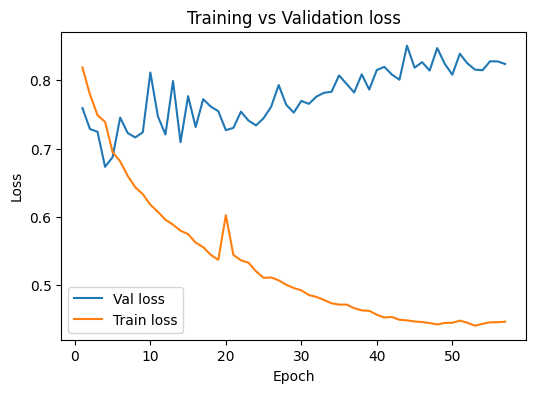

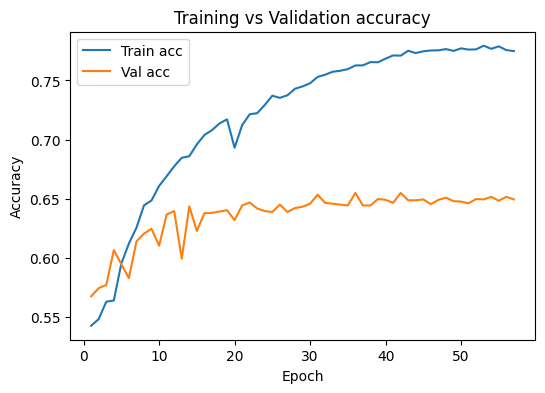

In [12]:
import matplotlib.pyplot as plt

epochs_r = range(1, len(train_losses) + 1)

plt.figure(figsize=(6,4))
def to_float(x):
    if torch.is_tensor(x):
        return x.detach().cpu().item()
    return float(x)

val_vals   = [to_float(v) for v in val_losses]
train_vals = [to_float(v) for v in train_losses]

plt.plot(epochs_r, val_vals,   label='Val loss')
plt.plot(epochs_r, train_vals, label='Train loss')


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation loss')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_r, train_accs, label='Train acc')
plt.plot(epochs_r, val_accs,  label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation accuracy')
plt.show()


In [13]:
# # === 重新实例化网络，与训练时配置保持一致 ===
best_net = Net(config, num_classes).to(device)

# # === 加载参数 ===
best_net.load_state_dict(torch.load(model_path, map_location=device,weights_only=False))

# best_net=copy.deepcopy(best_model)
best_net.eval()      # 切到推理模式


def pretty_print(split_name, metrics):
    acc, loss, prec, rec, f1, auc= metrics
    print(
        f"{split_name:<5} | "
        f"loss {loss:8.4f} | "
        f"acc {acc:6.4f} | "
        f"P {prec:6.4f} | "
        f"R {rec:6.4f} | "
        f"F1 {f1:6.4f}| "
        f"AUC {auc:6.4f}"
    )

# 评估
val_metrics  = evaluate(best_net, val_loader)
test_metrics = evaluate(best_net, test_loader)

# 打印
print("="*55)
pretty_print("VAL",  val_metrics)
pretty_print("TEST", test_metrics)
print("="*55)
# =======================================================
# VAL   | loss   0.7020 | acc 0.6633 | P 0.6138 | R 0.6066 | F1 0.6102| AUC 0.7241
# TEST  | loss   0.7449 | acc 0.6512 | P 0.6244 | R 0.6040 | F1 0.6140| AUC 0.7093
#ps 不知道为什么  这个cell 每次执行结果都会改变 

VAL   | loss   0.8050 | acc 0.6534 | P 0.5993 | R 0.6099 | F1 0.6046| AUC 0.7157
TEST  | loss   0.8462 | acc 0.6468 | P 0.6175 | R 0.6072 | F1 0.6123| AUC 0.7101


In [14]:
import numpy as np
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# —— 1. 设定长度分箱 ——（可自行调整）
length_bins = {
    "(0‑512]"     : (1,   512),
    "(512‑1k]"    : (513, 1023),
    "(1k‑1.5k]"   : (1024,1536),
    "(1.5k‑2k]"   : (1537,2048),
    "(2k‑4k]"     : (2049,4096),
    "(4k‑8k]"     : (4097,8191),
    "(8k‑inf]"    : (8192,99999999),
}

def bucket_metrics(model, dataloader, bins=length_bins, device='cpu'):
    """
    逐区间统计 acc / precision / recall / f1 / auc。
    返回 dict: {bucket_name: {'acc':…, 'pre':…, 'rec':…, 'f1':…, 'auc':…, 'total':…}}
    """
    model.eval()
    # 预置容器
    stats = {b: defaultdict(list) for b in bins}   # 每个 bucket 存放 y_true / y_pred / y_prob

    with torch.no_grad():
        for batch in dataloader:
            featb, adjb, maskb, labels = batch_to_tensor(batch, device)
            logits, _ = model(featb, adjb, maskb, train_consistency=False)

            # 取得预测类别 & 正类概率
            preds = logits.argmax(1).cpu().numpy()
            probs = torch.softmax(logits, dim=-1)[:, 1].cpu().numpy()
            labels_np = labels.cpu().numpy()

            # 实际 token 长度（去掉 <pad>）
            lengths = batch["attention_mask"].sum(dim=1).tolist()

            # 归入对应 bucket
            for y, p, prob, L in zip(labels_np, preds, probs, lengths):
                for bname, (lo, hi) in bins.items():
                    if lo <= L <= hi:
                        stats[bname]['y_true'].append(y)
                        stats[bname]['y_pred'].append(p)
                        stats[bname]['y_prob'].append(prob)
                        break

    # 计算指标
    results = {}
    for bname, d in stats.items():
        y_true = np.array(d['y_true'])
        y_pred = np.array(d['y_pred'])
        y_prob = np.array(d['y_prob'])
        total  = len(y_true)

        if total == 0:                      # 该区间无样本
            results[bname] = dict(acc=0, pre=0, rec=0, f1=0, auc=0, total=0)
            continue

        acc  = (y_true == y_pred).mean()
        pre, rec, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='binary', zero_division=0)

        # AUC 兼容单类别异常情况
        try:
            auc = roc_auc_score(y_true, y_prob)
        except ValueError:
            auc = 0.0

        results[bname] = dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, total=total)
    return results

# —— 2. 调用示例 ——
for name, loader in [ ("TEST", test_loader)]:
    metrics = bucket_metrics(best_net, loader, device=device)
    print(f"\n—— {name} ——")
    for b, m in metrics.items():
        print(f"{b:<10} 样本{m['total']:4d} | "
              f"ACC {m['acc']*100:6.2f}% | "
              f"P {m['pre']*100:6.2f}% | R {m['rec']*100:6.2f}% | "
              f"F1 {m['f1']*100:6.2f}% | AUC {m['auc']:.4f}")


# —— TEST ——
# (0‑512]    样本1860 | ACC  67.15% | P  66.72% | R  53.71% | F1  59.51% | AUC 0.7378
# (512‑1k]   样本 501 | ACC  58.48% | P  62.86% | R  43.48% | F1  51.40% | AUC 0.6431
# (1k‑1.5k]  样本 177 | ACC  63.84% | P  66.13% | R  48.81% | F1  56.16% | AUC 0.6523
# (1.5k‑2k]  样本  79 | ACC  55.70% | P  50.00% | R  40.00% | F1  44.44% | AUC 0.6409
# (2k‑4k]    样本  86 | ACC  55.81% | P  47.62% | R  27.03% | F1  34.48% | AUC 0.5041
# (4k‑8k]    样本  24 | ACC  79.17% | P 100.00% | R  37.50% | F1  54.55% | AUC 0.7344
# (8k‑inf]   样本   5 | ACC  60.00% | P   0.00% | R   0.00% | F1   0.00% | AUC 0.0000






—— TEST ——
(0‑512]    样本1860 | ACC  67.15% | P  64.74% | R  59.09% | F1  61.79% | AUC 0.7469
(512‑1k]   样本 501 | ACC  61.08% | P  61.60% | R  60.87% | F1  61.23% | AUC 0.6367
(1k‑1.5k]  样本 177 | ACC  61.02% | P  57.58% | R  67.86% | F1  62.30% | AUC 0.6759
(1.5k‑2k]  样本  79 | ACC  58.23% | P  51.72% | R  85.71% | F1  64.52% | AUC 0.5922
(2k‑4k]    样本  86 | ACC  47.67% | P  42.31% | R  59.46% | F1  49.44% | AUC 0.4881
(4k‑8k]    样本  24 | ACC  58.33% | P  42.86% | R  75.00% | F1  54.55% | AUC 0.7188
(8k‑inf]   样本   5 | ACC  20.00% | P   0.00% | R   0.00% | F1   0.00% | AUC 0.0000


In [15]:
def bucket_metrics_with_confusion(model, dataloader, bins=length_bins, device='cpu'):
    from collections import defaultdict
    model.eval()
    stats = {b: defaultdict(list) for b in bins}

    with torch.no_grad():
        for batch in dataloader:
            featb, adjb, maskb, labels = batch_to_tensor(batch, device)
            logits, _ = model(featb, adjb, maskb, train_consistency=False)

            preds = logits.argmax(1).cpu().numpy()
            probs = torch.softmax(logits, dim=-1)[:, 1].cpu().numpy()
            labels_np = labels.cpu().numpy()
            lengths = batch["attention_mask"].sum(dim=1).tolist()

            for y, p, prob, L in zip(labels_np, preds, probs, lengths):
                for bname, (lo, hi) in bins.items():
                    if lo <= L <= hi:
                        stats[bname]['y_true'].append(y)
                        stats[bname]['y_pred'].append(p)
                        stats[bname]['y_prob'].append(prob)
                        break

    results = {}
    for bname, d in stats.items():
        y_true = np.array(d['y_true'])
        y_pred = np.array(d['y_pred'])
        y_prob = np.array(d['y_prob'])
        total  = len(y_true)

        if total == 0:
            results[bname] = dict(acc=0, pre=0, rec=0, f1=0, auc=0, total=0,
                                  TP=0, TN=0, FP=0, FN=0)
            continue

        acc  = (y_true == y_pred).mean()
        pre, rec, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='binary', zero_division=0)
        try:
            auc = roc_auc_score(y_true, y_prob)
        except ValueError:
            auc = 0.0

        # 混淆矩阵组件
        TP = np.sum((y_true == 1) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))

        results[bname] = dict(acc=acc, pre=pre, rec=rec, f1=f1, auc=auc, total=total,
                              TP=TP, TN=TN, FP=FP, FN=FN)

    return results
metrics = bucket_metrics_with_confusion(best_net, test_loader, device=device)
print(f"\n—— Per Bucket Confusion ——")
for b, m in metrics.items():
    print(f"{b:<10} 样本{m['total']:4d} | "
          f"TP {m['TP']:4d} TN {m['TN']:4d} FP {m['FP']:4d} FN {m['FN']:4d} | "
          f"ACC {m['acc']*100:6.2f}% | P {m['pre']*100:6.2f}% | "
          f"R {m['rec']*100:6.2f}% | F1 {m['f1']*100:6.2f}% | AUC {m['auc']:.4f}")
    
# —— Per Bucket Confusion ——
# (0‑512]    样本1860 | TP  495 TN  758 FP  266 FN  341 | ACC  67.37% | P  65.05% | R  59.21% | F1  61.99% | AUC 0.7486
# (512‑1k]   样本 501 | TP  155 TN  153 FP   95 FN   98 | ACC  61.48% | P  62.00% | R  61.26% | F1  61.63% | AUC 0.6379
# (1k‑1.5k]  样本 177 | TP   57 TN   50 FP   43 FN   27 | ACC  60.45% | P  57.00% | R  67.86% | F1  61.96% | AUC 0.6779
# (1.5k‑2k]  样本  79 | TP   30 TN   17 FP   27 FN    5 | ACC  59.49% | P  52.63% | R  85.71% | F1  65.22% | AUC 0.5948
# (2k‑4k]    样本  86 | TP   22 TN   20 FP   29 FN   15 | ACC  48.84% | P  43.14% | R  59.46% | F1  50.00% | AUC 0.4903
# (4k‑8k]    样本  24 | TP    6 TN    8 FP    8 FN    2 | ACC  58.33% | P  42.86% | R  75.00% | F1  54.55% | AUC 0.7109
# (8k‑inf]   样本   5 | TP    0 TN    0 FP    3 FN    2 | ACC   0.00% | P   0.00% | R   0.00% | F1   0.00% | AUC 0.0000


—— Per Bucket Confusion ——
(0‑512]    样本1860 | TP  495 TN  758 FP  266 FN  341 | ACC  67.37% | P  65.05% | R  59.21% | F1  61.99% | AUC 0.7486
(512‑1k]   样本 501 | TP  155 TN  153 FP   95 FN   98 | ACC  61.48% | P  62.00% | R  61.26% | F1  61.63% | AUC 0.6379
(1k‑1.5k]  样本 177 | TP   57 TN   50 FP   43 FN   27 | ACC  60.45% | P  57.00% | R  67.86% | F1  61.96% | AUC 0.6779
(1.5k‑2k]  样本  79 | TP   30 TN   17 FP   27 FN    5 | ACC  59.49% | P  52.63% | R  85.71% | F1  65.22% | AUC 0.5948
(2k‑4k]    样本  86 | TP   22 TN   20 FP   29 FN   15 | ACC  48.84% | P  43.14% | R  59.46% | F1  50.00% | AUC 0.4903
(4k‑8k]    样本  24 | TP    6 TN    8 FP    8 FN    2 | ACC  58.33% | P  42.86% | R  75.00% | F1  54.55% | AUC 0.7109
(8k‑inf]   样本   5 | TP    0 TN    0 FP    3 FN    2 | ACC   0.00% | P   0.00% | R   0.00% | F1   0.00% | AUC 0.0000
